In [2]:
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed
from functools import partial

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from skmultilearn.problem_transform import LabelPowerset

import GPyOpt
from GPyOpt.experiment_design import initial_design
from xgboost import XGBClassifier

from scipy.io import mmread
from scipy.sparse import csr_matrix, vstack, hstack

import numpy as np
import matplotlib.pyplot as plt

import time
from scipy import stats

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt


In [ ]:
X_train, X_test, X_val = mmread('train_X.mtx').tocsr(), mmread('test_X.mtx').tocsr(), mmread('val_X.mtx').tocsr()
y_train, y_test, y_val = mmread('train_y.mtx').tocsr(), mmread('test_y.mtx').tocsr(), mmread('val_y.mtx').tocsr()

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val

(<51292x479611 sparse matrix of type '<class 'numpy.float64'>'
 	with 2661219 stored elements in Compressed Sparse Row format>,
 <26999x479611 sparse matrix of type '<class 'numpy.float64'>'
 	with 1450837 stored elements in Compressed Sparse Row format>,
 <30756x479611 sparse matrix of type '<class 'numpy.float64'>'
 	with 1598508 stored elements in Compressed Sparse Row format>,
 <51292x15091 sparse matrix of type '<class 'numpy.float64'>'
 	with 73357 stored elements in Compressed Sparse Row format>,
 <26999x15091 sparse matrix of type '<class 'numpy.float64'>'
 	with 38623 stored elements in Compressed Sparse Row format>,
 <30756x15091 sparse matrix of type '<class 'numpy.float64'>'
 	with 35186 stored elements in Compressed Sparse Row format>)

In [ ]:
def LabelPowerset_RF_predict(n_estimators, n_jobs, max_depth, X_train, y_train, X_test, criterion = 'gini'):
    
    # fits a random forest classifer with a lable powerset problem transformation
    # and outputs predictions.
    
    classifier = LabelPowerset(
        classifier = RandomForestClassifier(n_estimators = n_estimators, verbose = 2, n_jobs = n_jobs,
                                            max_depth = max_depth, criterion = criterion),
        require_dense = [False, True]
    )

    classifier.fit(X_train, y_train)
    
    print('starting prediction')
    predictions = classifier.predict(X_test)
    return(predictions)

In [ ]:
y = vstack((y_train, y_test, y_val))
X = vstack((X_train, X_test, X_val))

In [ ]:
transformer = LabelPowerset()

In [ ]:
y_trans = transformer.transform(y)

In [ ]:
new_y_train = y_trans[0:y_train.shape[0],]
new_y_test  = y_trans[y_train.shape[0]:(y_train.shape[0] + y_test.shape[0]),]
new_y_val   = y_trans[(y_train.shape[0] + y_test.shape[0]):y_trans.shape[0], ]

In [ ]:
new_y_test

array([15622, 15623,     1, ..., 13648, 13650, 15255])

In [35]:
def stacker_predict(n_estimators, max_depth, X_train, y_train, X_test, y_test, X_holdout, n_jobs = -1):
    
    # function to stack individual learners and predict class outputs
    # inputs: the tuned hyperparameters of our base random forest models
    # output: the class predictions
    
    def RF_predict(n_estimators, max_depth, X_train, y_train, X_test, X_holdout, n_jobs):
         # function which outputs the predictions for the the test and holdout sets
            
            classifier = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth,
                                               verbose = 2, n_jobs = n_jobs)
            classifier.fit(X_train, y_train)
            return(classifier.predict(X_test), classifier.predict(X_holdout))
    
    
    # train the individual learners and output their predictions as columns
    
    rf_0, holdout_0 = RF_predict(n_estimators = n_estimators[0], max_depth = max_depth[0], X_train = X_train,
                          y_train = y_train, X_test = X_test, X_holdout = X_holdout, n_jobs = n_jobs)
    
    rf_1, holdout_1 = RF_predict(n_estimators = n_estimators[1], max_depth = max_depth[1], X_train = X_train,
                          y_train = y_train, X_test = X_test, X_holdout = X_holdout, n_jobs = n_jobs)
    
    rf_2, holdout_2= RF_predict(n_estimators = n_estimators[2], max_depth = max_depth[2], X_train = X_train,
                          y_train = y_train, X_test = X_test, X_holdout = X_holdout, n_jobs = n_jobs)
    
    rf_3, holdout_3 = RF_predict(n_estimators = n_estimators[3], max_depth = max_depth[3], X_train = X_train,
                          y_train = y_train, X_test = X_test, X_holdout = X_holdout, n_jobs = n_jobs)
    
    # stack the columns to form a matrix to train our stacker on
    
    S_train = np.array([rf_0, rf_1, rf_2, rf_3])
    S_test  = np.array([holdout_0, holdout_1, holdout_2, holdout_3])
    
    # train the stacker and predict the holdout set
    
    stacker = LogisticRegression()
    print('training stacker')
    stacker.fit(S_train, y_test)
    
    print('predicting')
    stacker_predictions = stacker.predict(S_test)
    
    return(stacker_predictions)

In [4]:
def RF_predict(n_estimators, max_depth, X_train, y_train, X_test, X_holdout, n_jobs, min_samples_split = 2):
         # function which outputs the predictions for the the test and holdout sets
            
        classifier = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth,
                                               min_samples_split = min_samples_split, verbose = 2, n_jobs = n_jobs)
        classifier.fit(X_train, y_train)
        test_pred = classifier.predict(X_test)
        val_pred  = classifier.predict(X_holdout)
            
        return(test_pred, val_pred)
    
def XG_predict(n_estimators, max_depth, X_train, y_train, X_test, X_holdout, n_jobs):
    
    classifier = XGBClassifier(objective="multi:softprob", n_estimators = n_estimators,
                                       n_jobs = n_jobs, max_depth = max_depth)
    classifier.fit(X_train, y_train)
    test_pred = classifier.predict(X_test)
    val_pred  = classifier.predict(X_holdout)
            
    return(test_pred, val_pred)

def Ada_predict(n_estimators, X_train, y_train, X_test, X_holdout, n_jobs):
    
    classifier = AdaBoostClassifier(n_estimators = n_estimators, verbose = 2)
    
    classifier.fit(X_train, y_train)
    test_pred = classifier.predict(X_test)
    val_pred  = classifier.predict(X_holdout)
            
    return(test_pred, val_pred)

def Extra_predict(n_estimators, max_depth, X_train, y_train, X_test, X_holdout, n_jobs):
         # function which outputs the predictions for the the test and holdout sets
            
        classifier = ExtraTreesClassifier(n_estimators = n_estimators, verbose = 2, n_jobs = n_jobs,
                                            max_depth = max_depth)
        classifier.fit(X_train, y_train)
        test_pred = classifier.predict(X_test)
        val_pred  = classifier.predict(X_holdout)
            
        return(test_pred, val_pred)
    
def Extra_predict(n_estimators, max_depth, X_train, y_train, X_test, X_holdout, n_jobs):
         # function which outputs the predictions for the the test and holdout sets
            
        classifier = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
        classifier.fit(X_train, y_train)
        test_pred = classifier.predict(X_test)
        val_pred  = classifier.predict(X_holdout)
            
        return(test_pred, val_pred)
    

In [ ]:
xg_test_1, xg_val_1 = XG_predict(n_estimators = 100, max_depth = 100, X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 96)

In [ ]:
print(accuracy_score(xg_test_1, new_y_test))

In [12]:
test_preds_1, val_preds_1 = Extra_predict(n_estimators = 4, max_depth = 3000, X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 4building tree 2 of 4

building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=7)]: Done   4 out of   4 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   13.7s finished
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.5s finished


In [43]:
test_preds_2, val_preds_2 = RF_predict(n_estimators = 3, max_depth = 4500, X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3building tree 2 of 3

building tree 3 of 3


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  2.6min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.0s finished


In [38]:
test_preds_3, val_preds_3 = RF_predict(n_estimators = 3, max_depth = 4500, min_samples_split = 3,
                                       X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  3.0min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   18.7s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.3s finished


In [48]:
test_preds_4, val_preds_4 = RF_predict(n_estimators = 3, max_depth = 4500, min_samples_split = 4,
                                       X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.0s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.9s finished


In [52]:
test_preds_5, val_preds_5 = RF_predict(n_estimators = 3, max_depth = 4500, min_samples_split = 5,
                                       X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.5s finished


In [56]:
test_preds_6, val_preds_6 = RF_predict(n_estimators = 3, max_depth = 4500, min_samples_split = 6,
                                       X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.5s finished


In [60]:
test_preds_7, val_preds_7 = RF_predict(n_estimators = 3, max_depth = 4500, min_samples_split = 7,
                                       X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.0s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   16.9s finished


In [64]:
test_preds_8, val_preds_8 = RF_predict(n_estimators = 3, max_depth = 4500, min_samples_split = 8,
                                       X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  1.6min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.0s finished


In [68]:
test_preds_9, val_preds_9 = RF_predict(n_estimators = 3, max_depth = 4500, min_samples_split = 9,
                                       X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   17.1s finished


In [72]:
test_preds_10, val_preds_10 = RF_predict(n_estimators = 3, max_depth = 4500, min_samples_split = 10,
                                       X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.8s finished


In [76]:
test_preds_11, val_preds_11 = RF_predict(n_estimators = 3, max_depth = 4500, min_samples_split = 11,
                                       X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.8s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.9s finished


In [84]:
test_preds_15, val_preds_15 = RF_predict(n_estimators = 3, max_depth = 4500, min_samples_split = 15,
                                       X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s finished
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.3s finished


In [15]:
print(accuracy_score(new_y_test, test_preds_1), accuracy_score(new_y_val, val_preds_1))
print(accuracy_score(new_y_test, test_preds_2), accuracy_score(new_y_val, val_preds_2))



0.24845364643134932 0.250780335544284
0.2419719248861069 0.250780335544284


In [86]:
print(accuracy_score(new_y_test, test_preds_2), accuracy_score(new_y_val, val_preds_2))
print(accuracy_score(new_y_test, test_preds_3), accuracy_score(new_y_val, val_preds_3))
print(accuracy_score(new_y_test, test_preds_4), accuracy_score(new_y_val, val_preds_4))
print(accuracy_score(new_y_test, test_preds_5), accuracy_score(new_y_val, val_preds_5))
print(accuracy_score(new_y_test, test_preds_6), accuracy_score(new_y_val, val_preds_6))
print(accuracy_score(new_y_test, test_preds_7), accuracy_score(new_y_val, val_preds_7))
print(accuracy_score(new_y_test, test_preds_8), accuracy_score(new_y_val, val_preds_8))
print(accuracy_score(new_y_test, test_preds_9), accuracy_score(new_y_val, val_preds_9))
print(accuracy_score(new_y_test, test_preds_10), accuracy_score(new_y_val, val_preds_10))
print(accuracy_score(new_y_test, test_preds_11), accuracy_score(new_y_val, val_preds_11))
print(accuracy_score(new_y_test, test_preds_15), accuracy_score(new_y_val, val_preds_15))

0.22937886588392162 0.23660423982312395
0.23919404422386015 0.240928599297698
0.23778658468832178 0.24271686825334893
0.23323086040223712 0.23894524645597606
0.23689766287640282 0.23829496683573936
0.2361568946998037 0.24167642086097021
0.22845290566317272 0.23575887631681622
0.23074928701063002 0.23540122252568604
0.232490092225638 0.23595396020288725
0.22937886588392162 0.23130446091819482
0.22963813474573133 0.23244245025360905


In [87]:
full_test = np.array([test_preds_2, test_preds_3, test_preds_4, test_preds_5, test_preds_6, test_preds_7, test_preds_8, test_preds_9, test_preds_10, test_preds_11, test_preds_15])
full_val = np.array([val_preds_2, val_preds_3, val_preds_4, val_preds_5, val_preds_6, val_preds_7])

In [88]:
m = stats.mode(full_test)
print(accuracy_score(new_y_test, m[0][0]))

0.2964924626838031


In [ ]:
# best base learners: 15, 4500 - 12, 5000.
# max depth somewhere between 5000 and 10000 seems optimal
# larger scale: 60, 5000, 0.33 - 30, 5000, 0.32 - 20, 7000, 0.31

In [15]:
test_preds_1, val_preds_1 = RF_predict(n_estimators = 2, max_depth = 50000, X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 7)

building tree 1 of 1


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s finished


In [16]:
test_preds_2, val_preds_2 = RF_predict(n_estimators = 5, max_depth = 30000, X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 30)

building tree 1 of 2building tree 2 of 2



[Parallel(n_jobs=30)]: Done   2 out of   2 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   13.8s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   13.7s finished


In [9]:
test_preds_3, val_preds_3 = RF_predict(n_estimators = 15, max_depth = 8000, X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 15)
# approx 100GB of memory

building tree 1 of 15building tree 2 of 15
building tree 3 of 15building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15

building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15



[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:  2.5min remaining: 16.4min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  3.0min remaining:  1.5min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  3.0min finished
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:   55.7s remaining:  6.0min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:   56.9s remaining:   28.5s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:   57.2s finished
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:   57.1s remaining:  6.2min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:   58.9s remaining:   29.5s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:   58.9s finished


In [11]:
test_preds_4, val_preds_4 = RF_predict(n_estimators = 20, max_depth = 7000, X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 20)

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  2.5min remaining: 14.4min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  2.6min remaining:  1.1min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.7min finished
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  1.2min remaining:  6.6min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  1.2min remaining:   30.6s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  1.4min remaining:  8.2min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  1.4min remaining:   37.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  1.4min finished


In [13]:
test_preds_5, val_preds_5 = RF_predict(n_estimators = 30, max_depth = 5000, X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 30)

building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=30)]: Done   3 out of  30 | elapsed:  2.4min remaining: 21.5min
[Parallel(n_jobs=30)]: Done  19 out of  30 | elapsed:  2.5min remaining:  1.5min
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:  2.6min finished
[Parallel(n_jobs=30)]: Done   3 out of  30 | elapsed:  1.7min remaining: 15.0min
[Parallel(n_jobs=30)]: Done  19 out of  30 | elapsed:  1.7min remaining:   59.6s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:  1.7min finished
[Parallel(n_jobs=30)]: Done   3 out of  30 | elapsed:  2.1min remaining: 19.0min
[Parallel(n_jobs=30)]: Done  19 out of  30 | elapsed:  2.1min remaining:  1.2min
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:  2.1min finished


In [15]:
test_preds_6, val_preds_6 = RF_predict(n_estimators = 60, max_depth = 5000, X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 60)
# 161 GB of memory

building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60

building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60building tree 43 of 60
building tree 44 of 60

[Parallel(n_jobs=60)]: Done   3 out of  60 | elapsed:  3.6min remaining: 69.1min
[Parallel(n_jobs=60)]: Done  34 out of  60 | elapsed:  3.8min remaining:  2.9min
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:  4.0min finished
[Parallel(n_jobs=60)]: Done   3 out of  60 | elapsed:  3.3min remaining: 62.9min
[Parallel(n_jobs=60)]: Done  34 out of  60 | elapsed:  3.3min remaining:  2.5min
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:  3.3min finished
[Parallel(n_jobs=60)]: Done   3 out of  60 | elapsed:  3.7min remaining: 69.4min
[Parallel(n_jobs=60)]: Done  34 out of  60 | elapsed:  3.7min remaining:  2.8min
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:  3.7min finished


In [46]:
test_preds_7, val_preds_7 = RF_predict(n_estimators = 80, max_depth = 4500, X_train = X_train, y_train = new_y_train, X_test = X_test, X_holdout = X_val, n_jobs = 80)
# 115 GB

building tree 1 of 15building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15

building tree 15 of 15


[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:  1.9min remaining: 12.1min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  1.9min remaining:   56.8s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  2.0min finished
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:   51.2s remaining:  5.5min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:   52.5s remaining:   26.2s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:   52.5s finished
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:   52.3s remaining:  5.7min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:   53.0s remaining:   26.5s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:   53.2s finished


In [16]:
#print(accuracy_score(new_y_test, test_preds_1), accuracy_score(new_y_val, val_preds_1))
#print(accuracy_score(new_y_test, test_preds_2), accuracy_score(new_y_val, val_preds_2))
print(accuracy_score(new_y_test, test_preds_3), accuracy_score(new_y_val, val_preds_3))
print(accuracy_score(new_y_test, test_preds_4), accuracy_score(new_y_val, val_preds_4))
print(accuracy_score(new_y_test, test_preds_5), accuracy_score(new_y_val, val_preds_5))
print(accuracy_score(new_y_test, test_preds_6), accuracy_score(new_y_val, val_preds_6))
#print(accuracy_score(new_y_test, test_preds_7), accuracy_score(new_y_val, val_preds_7))

0.3133449387014334 0.3124593575237352
0.32449349975925035 0.3212706463779425
0.331604874254602 0.3225061776563922
0.34156820622986034 0.3333333333333333


In [32]:
full_test = np.array([test_preds_3, test_preds_6])
full_val = np.array([val_preds_3, val_preds_4, val_preds_5, val_preds_6])

In [33]:
m = stats.mode(full_test)
print(accuracy_score(new_y_test, m[0][0]))

In [60]:
trans_1 = transformer.inverse_transform(test_preds_1)
trans_2 = transformer.inverse_transform(test_preds_2)
trans_3 = transformer.inverse_transform(test_preds_3)
trans_4 = transformer.inverse_transform(test_preds_4)
trans_5 = transformer.inverse_transform(test_preds_5)
trans_6 = transformer.inverse_transform(test_preds_6)
trans_7 = transformer.inverse_transform(test_preds_7)

In [61]:
full_trans = hstack((trans_1, trans_3, trans_5, trans_6, trans_7))

In [62]:
full_trans, len(new_y_test)

(<26999x75455 sparse matrix of type '<class 'numpy.int64'>'
 	with 211014 stored elements in COOrdinate format>, 26999)

In [63]:
stacker = LogisticRegression(n_jobs = 32)

In [64]:
stacker.fit(full_trans, new_y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=32,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [83]:
val_1 = transformer.inverse_transform(val_preds_1)
val_2 = transformer.inverse_transform(val_preds_2)
val_3 = transformer.inverse_transform(val_preds_3)
val_4 = transformer.inverse_transform(val_preds_4)
val_5 = transformer.inverse_transform(val_preds_5)
val_6 = transformer.inverse_transform(val_preds_6)
val_7 = transformer.inverse_transform(val_preds_7)

val_trans = hstack((val_1, val_3, val_4, val_6, val_7))

In [84]:
val_predictions = stacker.predict(val_trans)

In [85]:
print(accuracy_score(new_y_val, val_predictions))  # 0.260 -> 0.2632 -> 0.2673
                                                   

0.2917154376381844


In [ ]:
# Since the stacker is very slow but only requires a small amount of memory (< 20GB), save the predictions of each of the base learners (e.g. to .csv)
# and then have the stackers running in parallel trying out different combinations of base model. Then choose stackers that seem overdispersed (if possible)
# and model average them. 

In [99]:
m_val = stats.mode(full_val)

In [100]:
print(accuracy_score(new_y_val, m_val[0][0]))

0.28729353622057485


In [12]:
##################### plots
plt.figure(figsize=(50,50))
plt.style.use('ggplot')

<Figure size 3600x3600 with 0 Axes>

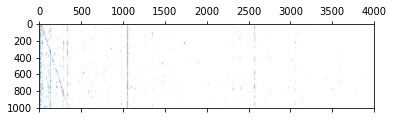

In [33]:
fig = plt.spy(X[0:1000, 0:4000], markersize = 0.004)

In [36]:
plt.savefig('test.png')

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Rows of the data matrix')

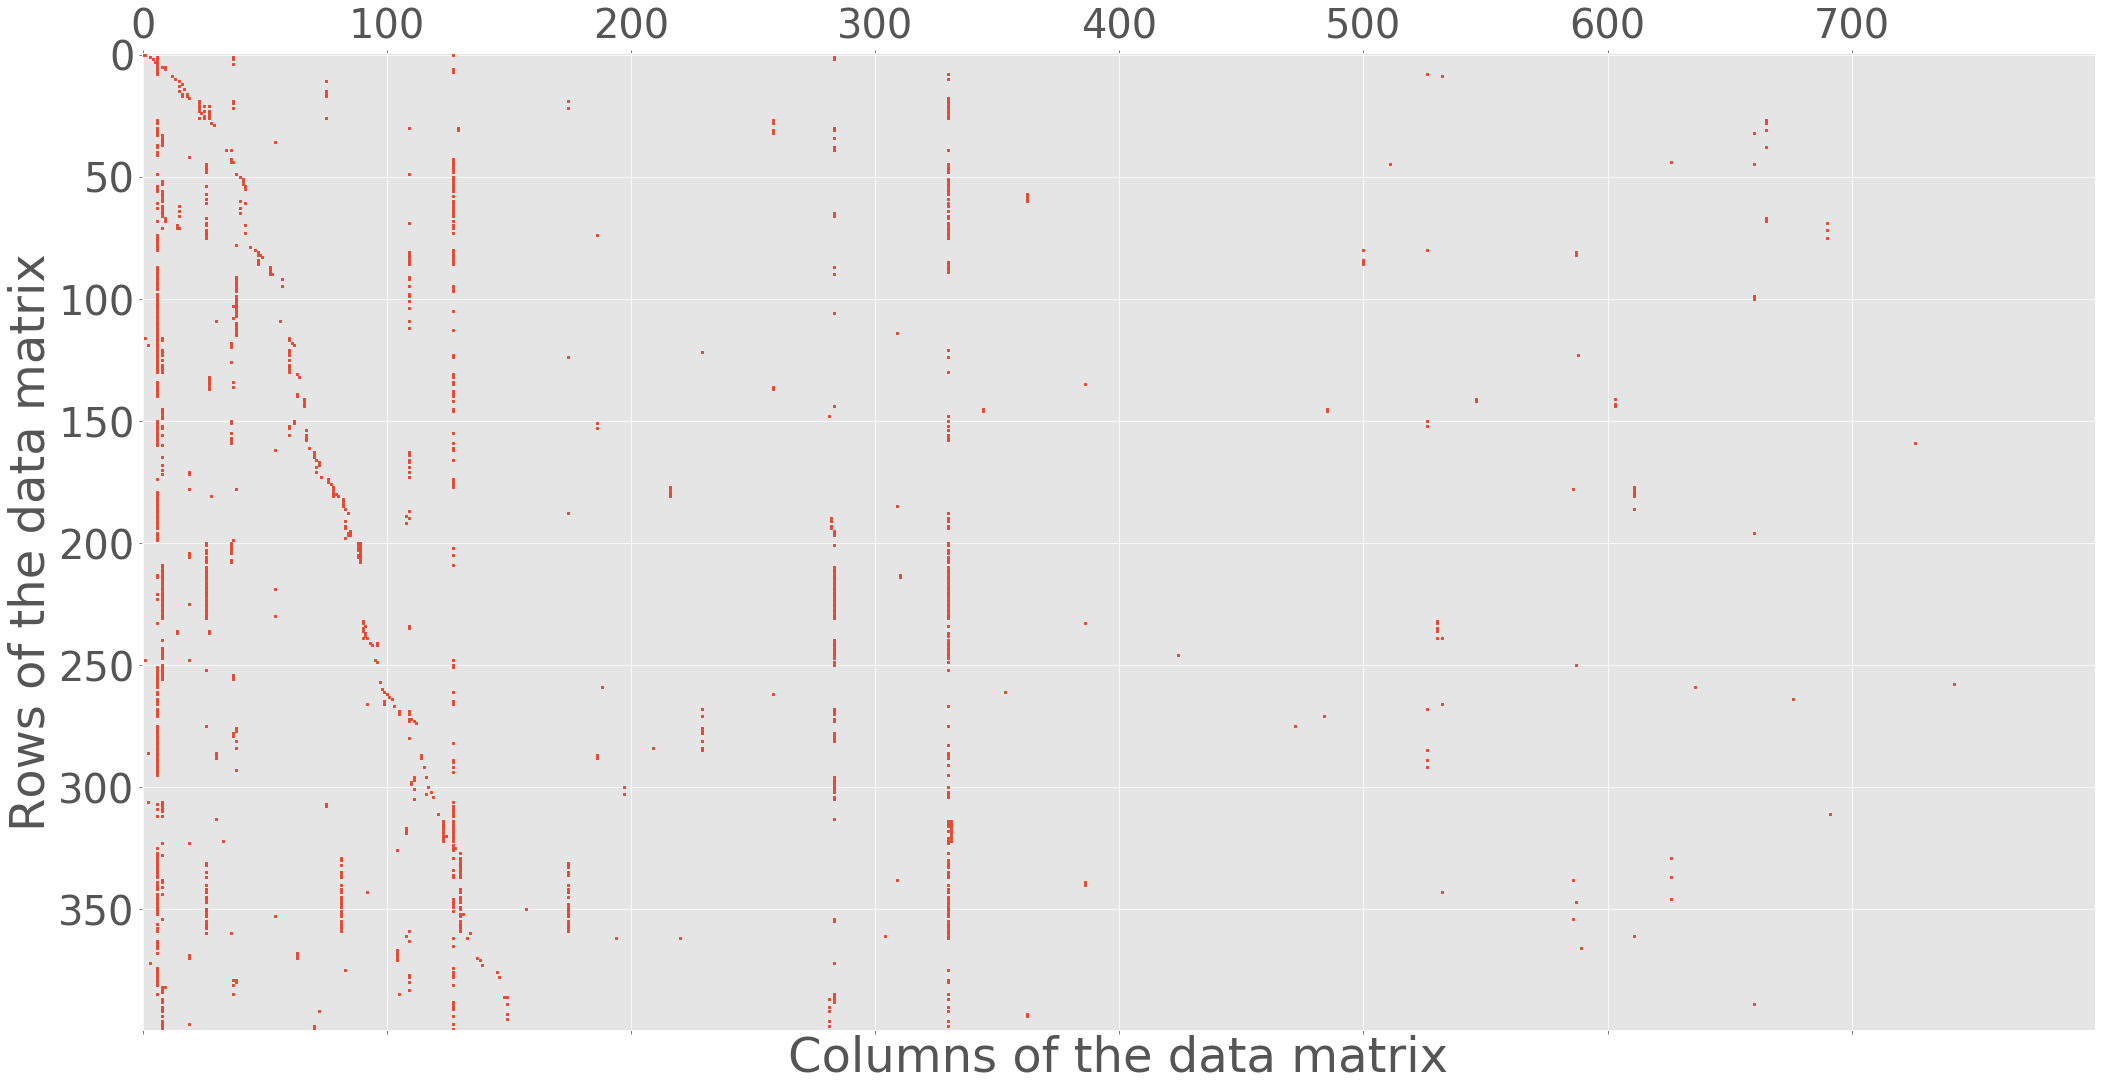

In [19]:
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots(figsize=(35, 35))
ax.spy(X[0:400, 0:800], markersize = 2)
plt.xlabel('Columns of the data matrix')
plt.ylabel('Rows of the data matrix')

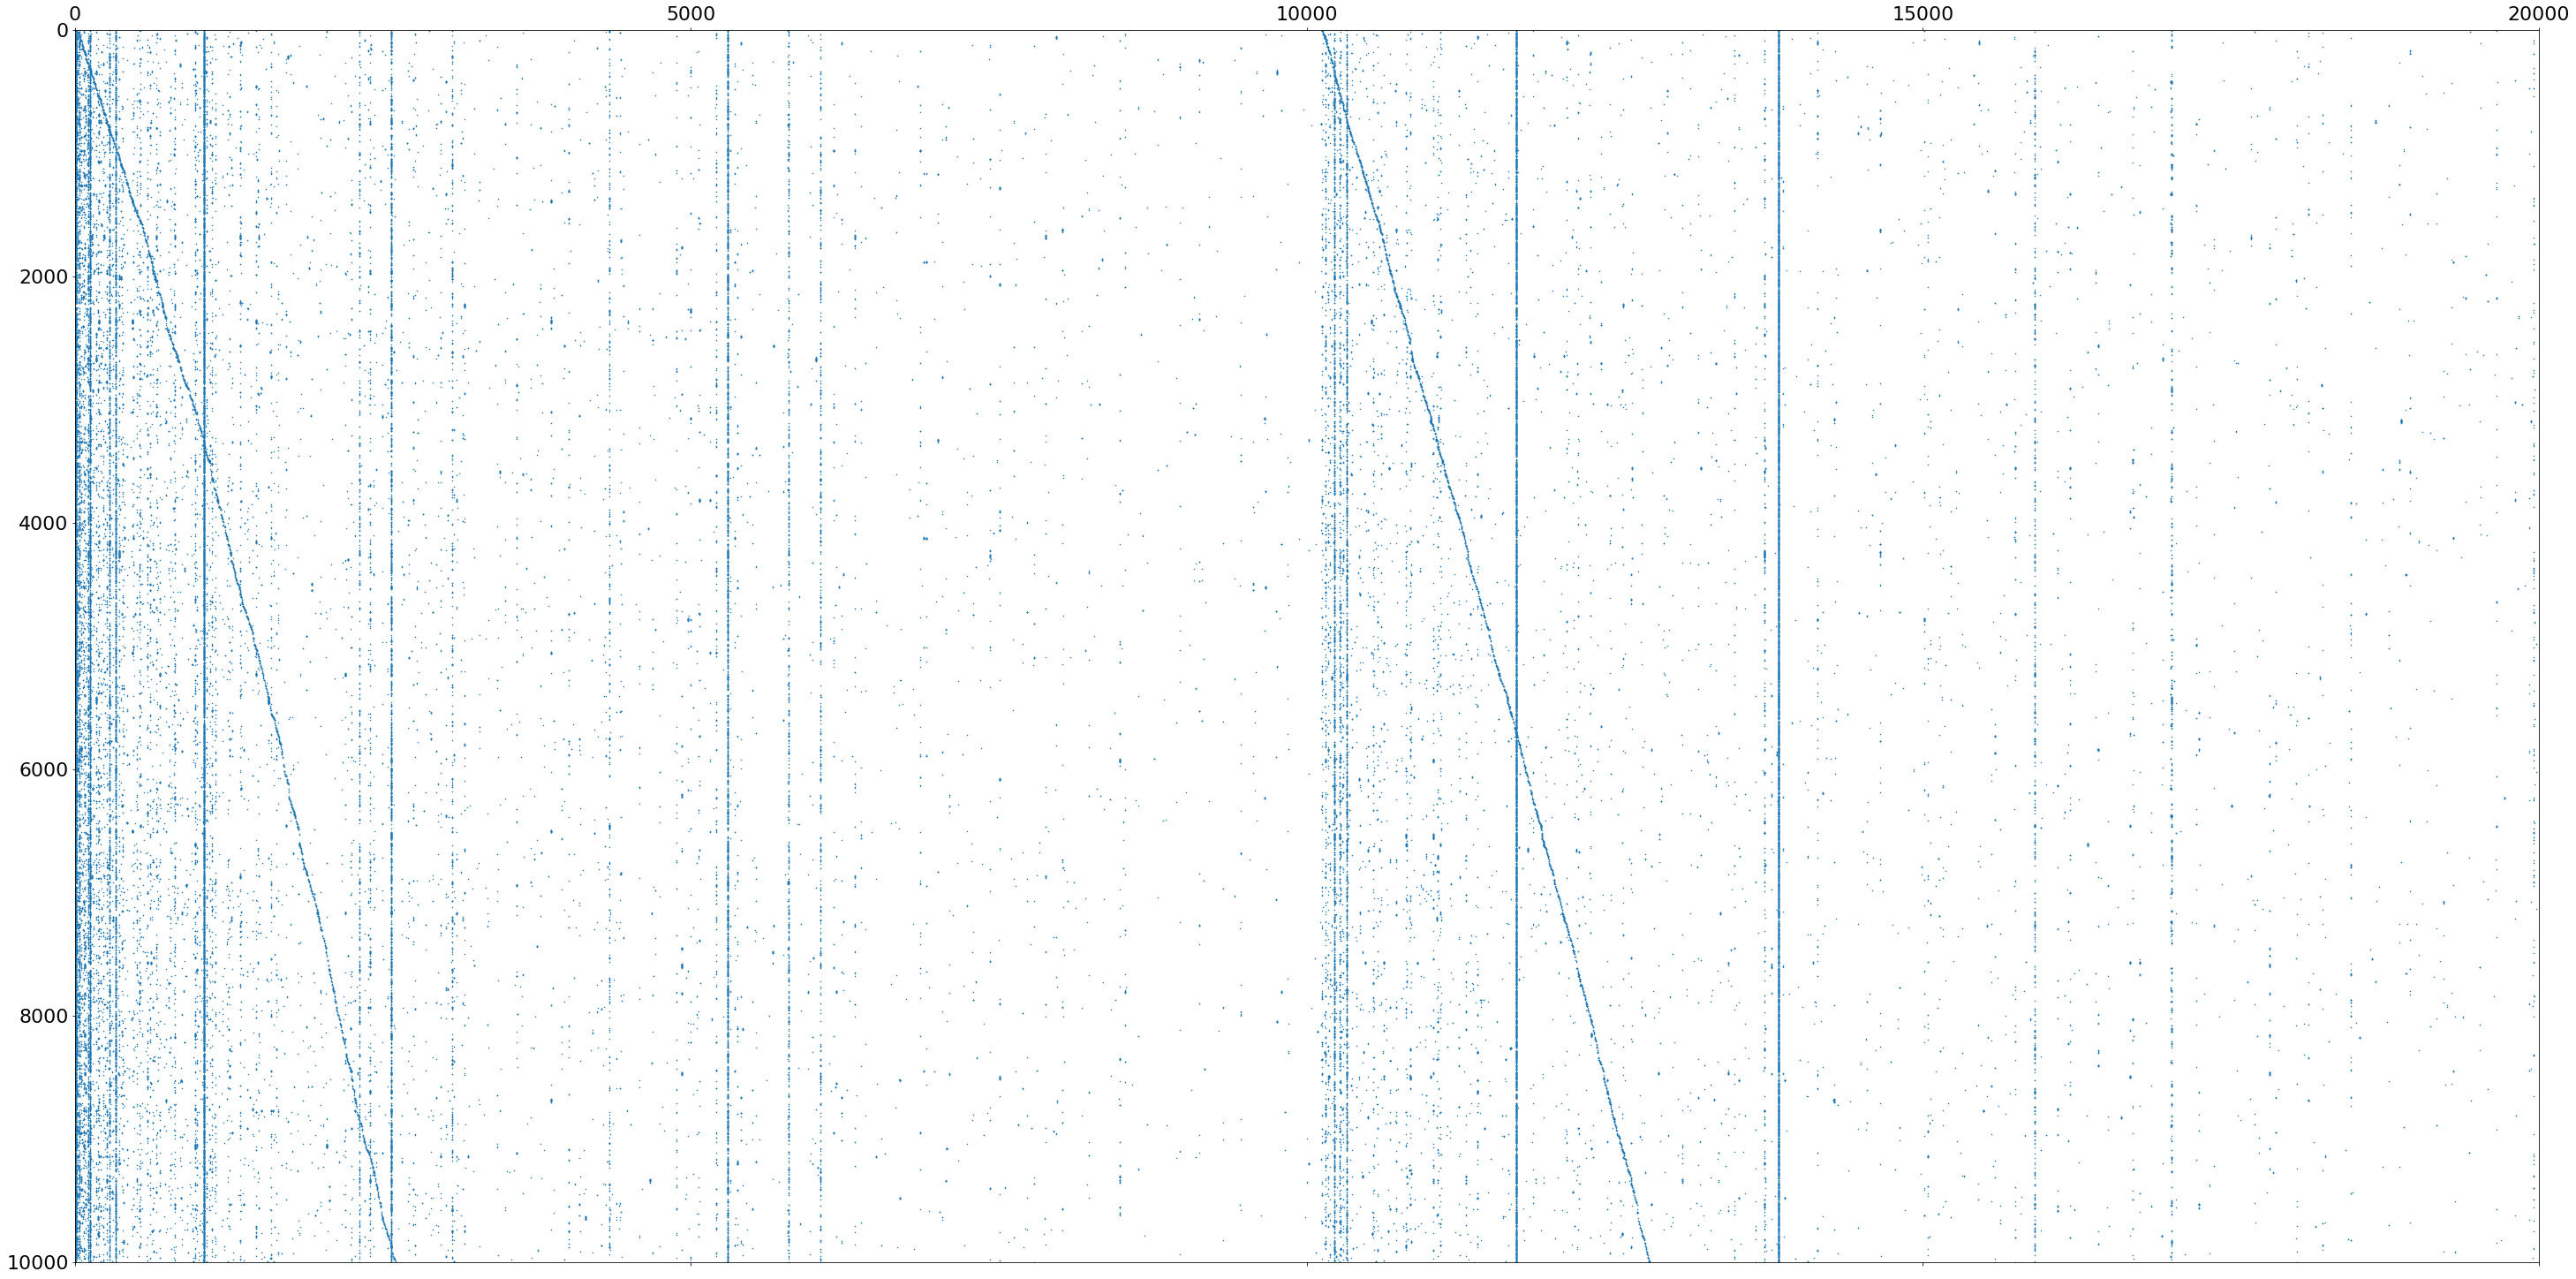

In [59]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(50, 50))
ax.spy(X[0:10000, 0:20000], markersize = 0.5)

In [71]:
X, y

(<109047x479611 sparse matrix of type '<class 'numpy.float64'>'
 	with 5710564 stored elements in Compressed Sparse Row format>,
 <109047x15091 sparse matrix of type '<class 'numpy.float64'>'
 	with 147166 stored elements in Compressed Sparse Row format>)

In [72]:
print(5710564*100/(109047*479611))
print(147166*100/(109047*15091))


0.010918831042731399
0.00894284584537435


In [7]:
col_sums = y.sum(axis = 0)

In [53]:
col_sums[col_sums == 2].shape[1]

0

In [50]:
freq = np.zeros(230)
for i in range(230):
    freq[i] = col_sums[col_sums == i].shape[1]
    

In [ ]:
### dimensionality reduction ####

In [75]:
from sklearn.decomposition import TruncatedSVD

In [76]:
svd = TruncatedSVD(n_components = 500, n_iter = 7, random_state = 42)

In [77]:
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=500, n_iter=7,
       random_state=42, tol=0.0)

In [78]:
print(svd.explained_variance_ratio_.cumsum()) # 100 explains 35%

[0.01233829 0.03263193 0.04852786 0.06426599 0.07709898 0.08773757
 0.09797265 0.10700018 0.11574229 0.12375381 0.13140672 0.1383023
 0.14468194 0.15077528 0.15658795 0.16209001 0.1674343  0.17253582
 0.17738863 0.18213733 0.18655403 0.19095239 0.19520929 0.19934473
 0.20328392 0.20718218 0.21100533 0.21476396 0.21839265 0.22193412
 0.22545121 0.22887257 0.23212399 0.23530107 0.23845379 0.24155902
 0.24450838 0.24737784 0.25019215 0.25296718 0.25563381 0.25824965
 0.26082995 0.26339209 0.26585636 0.26830804 0.27068752 0.27300219
 0.27527534 0.27752855 0.27966487 0.28179448 0.28390685 0.28597018
 0.28800162 0.28994759 0.29185302 0.29373758 0.29559873 0.297444
 0.29923946 0.30099056 0.30272196 0.30445228 0.30614445 0.30781136
 0.30946558 0.31109777 0.3127045  0.3142839  0.31584392 0.31739795
 0.3189291  0.32043821 0.32191775 0.32338931 0.32484565 0.32627966
 0.32769826 0.32909639 0.33048451 0.33185955 0.33320947 0.33454787
 0.33587359 0.33718717 0.33849875 0.33978345 0.34105816 0.3423217

NameError: name 'svd' is not defined

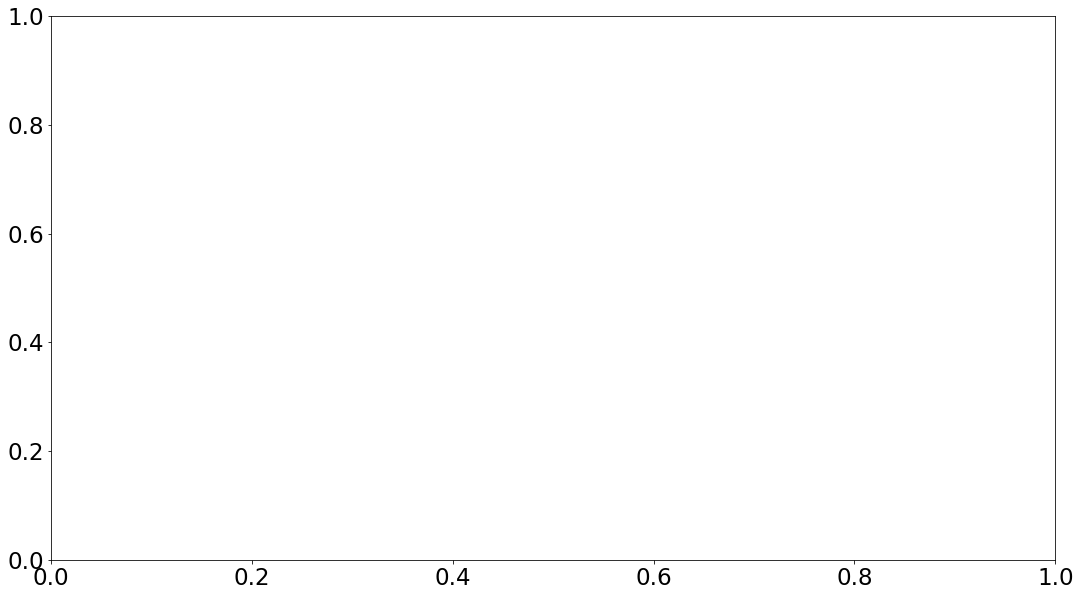

In [3]:
plt.rcParams.update({'font.size': 23})

fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylim(bottom = 0, top = 1)
plt.show()

In [145]:
np.argmax(max(y.sum(axis = 0)))

15022

In [182]:
inds_400 = np.where(np.array(y[:, 400].todense()) == 1)[0]
inds_500 = np.where(np.array(y[:, 500].todense()) == 1)[0]
inds_600 = np.where(np.array(y[:, 600].todense()) == 1)[0]

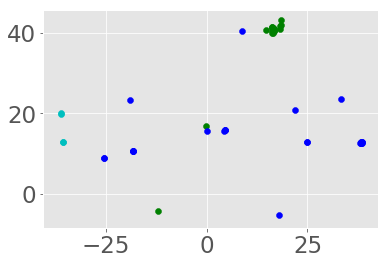

In [184]:
plt.scatter(X_embedded_100[inds_400, 0], X_embedded_100[inds_400, 1], c = 'g')
plt.scatter(X_embedded_100[inds_500, 0], X_embedded_100[inds_500, 1], c = 'b')
plt.scatter(X_embedded_100[inds_600, 0], X_embedded_100[inds_600, 1], c = 'c')

In [107]:
from sklearn.manifold import TSNE

In [108]:
svd_50 = TruncatedSVD(n_components = 50, n_iter = 7, random_state = 42)

In [109]:
X_50 = svd_50.fit_transform(X)

In [ ]:
X_embedded_30 = TSNE(n_components=2, perplexity = 30).fit_transform(X_50)

Text(0, 0.5, 'TSNE Dimension 2')

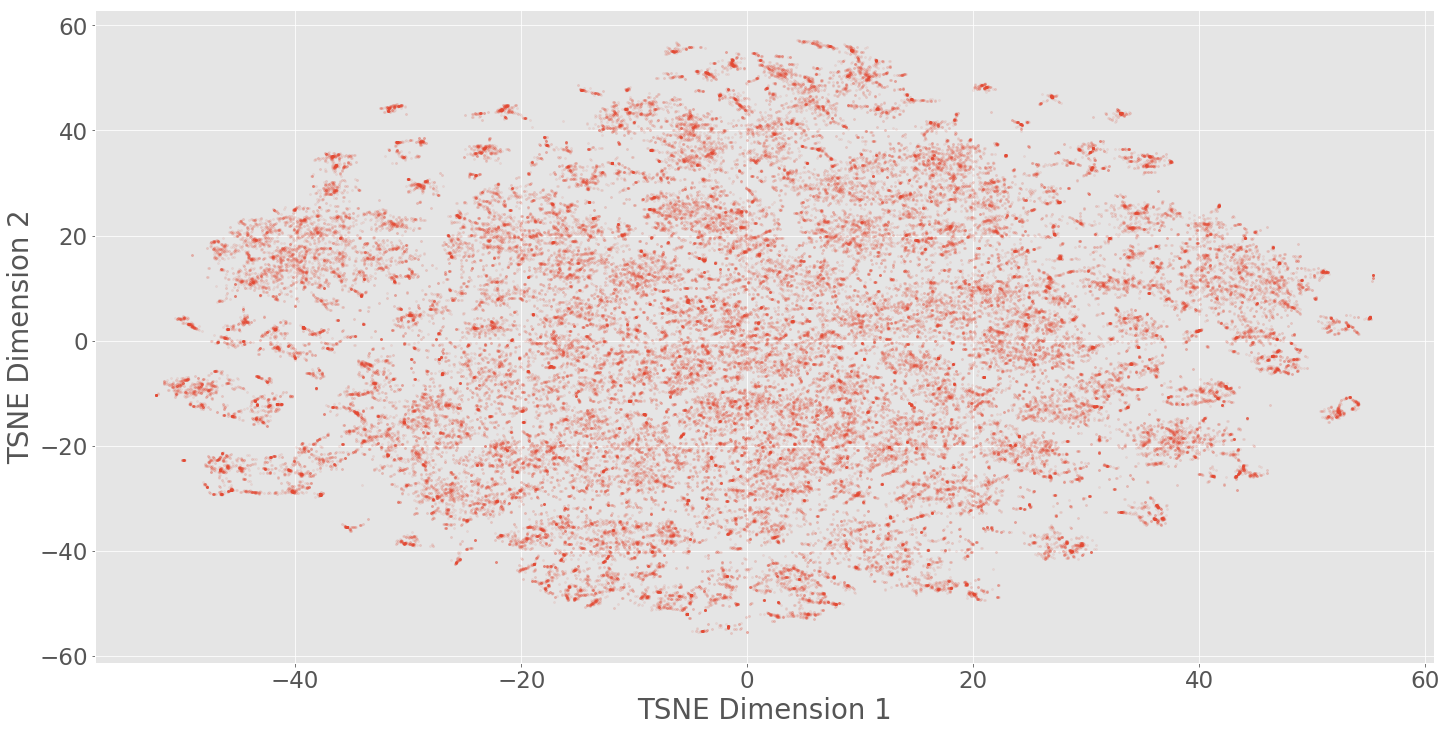

In [194]:
fig, ax = plt.subplots(figsize=(20*1.2, 10*1.2))
plt.scatter(X_embedded_100[:, 0], X_embedded_100[:,1], alpha = 0.1, s = 4)
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')